# 🚚 **Projet EcoRoute — Livrable 1 : Modélisation conceptuelle**

![alt text](<Project Banner.png>)

**ADEME — Optimisation des tournées de livraison durable**

**Résumé** : ce notebook présente la modélisation conceptuelle du problème de tournées de livraison. Il définit le périmètre, les hypothèses, les données attendues, la formulation mathématique succincte, la complexité théorique et fournit des TODOs pour la transition vers le notebook technique.


---

## **0. Objectif du livrable**

Ce premier livrable a pour but de :
>
> - Formaliser le problème en langage graphique et mathématique.
> - Lister les données et formats exigés pour l'implémentation.
> - Établir la complexité théorique et les implications méthodologiques.
> - Préparer des repères et TODOs pour la phase technique (Livrable 2).
>


---

## **1. Contexte**

L'essor fulgurant du **e-commerce** et des **livraisons rapides** a profondément transformé les réseaux logistiques. Cette accélération s’accompagne d’une hausse considérable des **émissions de CO₂** et d’une **consommation énergétique** croissante.

Face à ces enjeux, l’**ADEME** (_Agence de la Transition Écologique_) a lancé un **Appel à Manifestation d’Intérêt (AMI)** pour encourager le développement de solutions innovantes de **mobilité durable**.

Notre équipe **CesiCDP** a été mandatée pour concevoir un modèle d’optimisation des tournées de livraison visant à concilier **performance logistique** et **impact environnemental réduit**.

Le problème étudié est une extension du **Problème de Tournées de Véhicules** (_VRP — Vehicle Routing Problem_), dont l’objectif est de déterminer l’itinéraire optimal pour une flotte de véhicules afin de :

- **minimiser la distance et la durée totales des trajets,**
- **maximiser l’efficacité énergétique et la productivité,**
- **garantir le respect des contraintes opérationnelles.**

Afin d’assurer une modélisation fidèle aux contraintes industrielles, deux dimensions avancées sont intégrées dès ce livrable :

- **Fenêtres de Temps (_Time Windows_)** : chaque client possède un créneau horaire défini. Le livreur peut arriver en avance et attendre sur site.
- **Flotte Multiple** : plusieurs véhicules identiques (*k* camions) sont utilisés simultanément. L’objectif est de **minimiser le temps de retour du dernier véhicule (_Makespan_)**.


---

## **2. Problématique**

> ***Comment planifier les tournées de livraison pour minimiser coûts opérationnels et impact environnemental tout en respectant les contraintes réelles (fenêtres de temps, capacités, trafic) ?***

Ce problème est une extension du **Vehicle Routing Problem (VRP)**. Les variantes pertinentes ici sont :
- **VRPTW** (fenêtres temporelles),
- **Heterogeneous VRP** (flotte hétérogène),
- **Time-dependent VRP** (temps de parcours en fonction de l'heure).


---

## **3. Hypothèses de modélisation**

Les hypothèses retenues pour ce livrable :

1. **Points de collecte et de livraison** : modélisés comme **nœuds** d'un graphe.
2. **Arêtes** : représentent des trajets routiers.
3. **Attributs des arêtes** : chaque arête possède une **distance** et un vecteur de **temps de parcours par tranche horaire** (modèle *piecewise-constant*).
4. **Véhicules** : ressources avec capacités multi-dimensionnelles (poids, volume, etc.).
5. **Compatibilité** : certains objets exigent des contraintes de compatibilité véhicule-objet.
6. **Objectif** : combine distance, temps et estimation CO₂ (pondération paramétrable).
7. **Tournées** : commencent et se terminent au dépôt (ou dépôts multiples selon l'extension).


---

## **4. Représentation formelle (synthèse)**

Nous utilisons un graphe dirigé pondéré dynamique : **G = (V, E)**.

**Ensembles et paramètres** :
- V : nœuds (dépôt(s), points de collecte, points de livraison).
- E : arêtes (i,j) représentant trajets possibles.
- P : ensemble d'objets à collecter/livrer. Pour p∈P, c(p) est le nœud collecte et d(p) le nœud livraison.
- K : ensemble de véhicules.


### **Paramètres** :
- $x_{ij}^k \in \{0,1\}$ : l’arête $i \to j$ est parcourue par le véhicule $k$.
- $t_i$ : temps d’arrivée au nœud $i$.
- $y_p^k \in \{0,1\}$ : l’objet $p$ est affecté au véhicule $k$.

**Objectif (exemple pondéré)** :
*Insérer Schéma*

### **Code de test pour simulation du problème**
> Ce bout de code doit permettre d'avoir une vue d'ensemnble sur le problème général.

| Élément            | Description                                             | Exemple concret                                 |
|--------------------|--------------------------------------------------------|-------------------------------------------------|
| **Dépôt (node 0)** | Point de départ et d’arrivée de toutes les tournées    | Siège logistique principal                      |
| **Clients (1–8)**  | Lieux de livraison avec contraintes                    | Client 3 → 120 kg, fenêtre 10h–13h              |
| **Arêtes (edges)** | Routes entre deux points avec pondération multi-critères | Distance : 4.5 km, Temps : 27 min, CO₂ : 0.8 kg |
| **Flotte**         | Liste des véhicules disponibles et leurs capacités     | V2 : 650 kg, électrique                         |
| **Graphe NetworkX**| Structure manipulable pour calculs d’itinéraires       | `nx.DiGraph` pour modéliser les trajets dirigés  |

### **Import des Bibliothèques**
> Les library nécessaires à la bonne modélisation de notre problème

In [1]:
# ============================================================
# 🚚 Modélisation du problème VRP — Projet EcoRoute / ADEME
# ============================================================

import networkx as nx
import random
import pandas as pd


In [2]:
# -----------------------------
# 1. Définition des paramètres
# -----------------------------

N_CLIENTS = 8
N_VEHICULES = 3
SEED = 42
random.seed(SEED)

# Fenêtres temporelles simulées (heures en minutes)
TIME_WINDOWS = [(480, 600), (540, 720), (600, 780), (660, 840),
                (720, 900), (780, 960), (840, 1020), (900, 1080)]

# -----------------------------
# 2. Génération du graphe
# -----------------------------

G = nx.complete_graph(N_CLIENTS + 1, create_using=nx.DiGraph())  # +1 pour le dépôt
positions = {}

# Ajout du dépôt (node 0)
G.nodes[0]['type'] = 'depot'
G.nodes[0]['location'] = (0, 0)
G.nodes[0]['time_window'] = (480, 1080)  # 8h00 - 18h00
positions[0] = (0, 0)

In [3]:
# -----------------------------
# 3. Ajout des clients
# -----------------------------
for i in range(1, N_CLIENTS + 1):
    G.nodes[i]['type'] = 'client'
    G.nodes[i]['demand_kg'] = random.randint(50, 200)
    G.nodes[i]['location'] = (random.uniform(1, 10), random.uniform(1, 10))
    G.nodes[i]['time_window'] = TIME_WINDOWS[i - 1]
    G.nodes[i]['priority'] = random.choice(['normale', 'haute'])
    positions[i] = G.nodes[i]['location']

# -----------------------------
# 4. Pondération des arêtes
# -----------------------------
for i in G.nodes:
    for j in G.nodes:
        if i != j:
            x1, y1 = G.nodes[i]['location']
            x2, y2 = G.nodes[j]['location']
            distance = ((x2 - x1)**2 + (y2 - y1)**2)**0.5

            # Variation du temps de trajet selon l’heure (facteur simplifié)
            traffic_factor = random.uniform(1.0, 1.5)
            time = distance * traffic_factor * 6  # minutes (≈10 km/h)

            # Coût environnemental simplifié
            co2 = distance * random.uniform(0.12, 0.25)  # kg CO₂/km

            G[i][j]['distance_km'] = round(distance, 2)
            G[i][j]['time_min'] = round(time, 1)
            G[i][j]['co2_kg'] = round(co2, 3)

In [4]:
# -----------------------------
# 5. Flotte de véhicules
# -----------------------------
vehicules = pd.DataFrame([
    {'id': f'V{i+1}', 'cap_kg': random.randint(400, 700),
     'dispo': (480, 1080), 'type': random.choice(['électrique', 'diesel'])}
    for i in range(N_VEHICULES)
])



### **Visualisation des données**

=== DÉPÔT ===
{'type': 'depot', 'location': (0, 0), 'time_window': (480, 1080)}

=== CLIENTS ===
Client 1 : {'type': 'client', 'demand_kg': 78, 'location': (1.2250967970040025, 3.4752638653220735), 'time_window': (480, 600), 'priority': 'normale'}
Client 2 : {'type': 'client', 'demand_kg': 85, 'location': (7.628240927476112, 7.0902953868062015), 'time_window': (540, 720), 'priority': 'normale'}
Client 3 : {'type': 'client', 'demand_kg': 158, 'location': (1.2860441153360522, 1.843257158754332), 'time_window': (600, 780), 'priority': 'normale'}
Client 4 : {'type': 'client', 'demand_kg': 179, 'location': (6.418168561449823, 6.051205566447517), 'time_window': (660, 840), 'priority': 'haute'}
Client 5 : {'type': 'client', 'demand_kg': 106, 'location': (5.042881416554683, 3.5037163740759647), 'time_window': (720, 900), 'priority': 'normale'}
Client 6 : {'type': 'client', 'demand_kg': 90, 'location': (7.283254554894041, 4.062254648661927), 'time_window': (780, 960), 'priority': 'normale'}
Cli

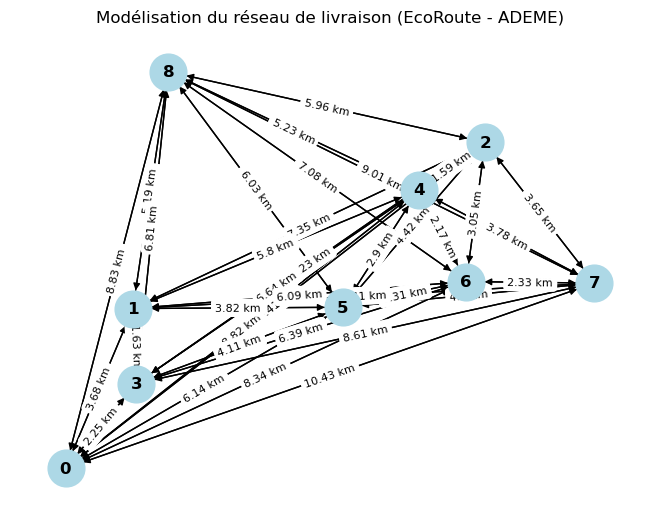

In [5]:
# -----------------------------
# 6. Affichage synthétique
# -----------------------------
print("=== DÉPÔT ===")
print(G.nodes[0])
print("\n=== CLIENTS ===")
for i in range(1, N_CLIENTS + 1):
    print(f"Client {i} :", G.nodes[i])

print("\n=== FLOTTE DE VÉHICULES ===")
print(vehicules)

print("\n=== Exemple de pondération (arête 0→1) ===")
print(G[0][1])

# -----------------------------
# 7. Visualisation du graphe
# -----------------------------
import matplotlib.pyplot as plt

edge_labels = {(i, j): f"{G[i][j]['distance_km']} km" for i, j in G.edges}
nx.draw(G, positions, with_labels=True, node_size=700, node_color="lightblue", font_weight='bold')
nx.draw_networkx_edge_labels(G, positions, edge_labels=edge_labels, font_size=8)
plt.title("Modélisation du réseau de livraison (EcoRoute - ADEME)")
plt.show()


### Objectifs du Code :
 => Construire un Graphe Pondéré Orienté, lequel permet de modéliser :
- Un dépot central, 
- Plusieurs Clients avec des fênetres temporelles 
- Une flotte de véhicules avec capacités et disponibilités accessibles, 
- Et des liaisons routières pondérées par distance, temps, et cout environnemental.

---

## 5. Contraintes (détail et exemples)

**Contraintes fondamentales** :

1. *Visite unique* : chaque point de livraison fixé doit être desservi une fois (ou marqué comme non-servi avec pénalité).

2. *Capacité* : pour tout véhicule $k$ et chaque ressource $r$, la charge cumulée ne dépasse pas $Q_k^{(r)}$.

3. *Fenêtres temporelles* : l'arrivée $t_i$ doit satisfaire $a_i \leq t_i \leq b_i$ ; l'attente est autorisée si nécessaire.

4. *Pickup & delivery* : pour chaque objet $p$ affecté à $k$, la visite du nœud collecte $c(p)$ précède celle de $d(p)$.

5. *Compatibilité* : $y_p^k \leq \text{compat}_{k,p}$.

6. *Temps dépendant* : si $x_{ij}^k=1$ avec départ à $t_i$, alors $t_j \geq t_i + s_i + t_{ij}^{\tau(t_i)}$.

**Exemples courts** :
- Cas fenêtre temporelle : si un client accepte livraison entre $9\text{h}–11\text{h}$ et le camion arrive à $8\text{h}50$, il peut attendre jusqu'à $9\text{h}$.
- Cas compatibilité : colis réfrigéré $\rightarrow$ nécessaire véhicule équipé réfrigération ($\text{compat}_{k,p}=1$ sinon $0$).


---

## **6. Complexité théorique (explication pédagogique)**

**Pourquoi se préoccuper de la complexité ?**
- Le choix d'une méthode dépend de la classe de complexité du problème de décision associé.
- Si le problème est NP‑complet, rechercher une garantie d'optimalité sur de grandes instances devient impraticable.

**Remarque clé (intuitive)** : la version basique du TSP est NP‑complet. Les variantes du VRP (VRPTW, HVRP, TDVRP) restent, au sens général, NP‑difficiles ou NP‑complets pour les problèmes de décision associés.

**Conséquences pratiques** :
- Pour des instances de taille faible à moyenne (n ≲ 100), les méthodes exactes (PLNE, Branch & Cut) peuvent être envisageables.
- Pour des instances réelles (n > 1000), il faut privilégier **heuristiques et métaheuristiques** (ALNS, Tabu, Simulated Annealing, etc.).

**Petite preuve d'appartenance à NP (idée)** :
- On montre qu'un certificat (une affectation de clients aux tournées et un ordre de visite) permet de vérifier en temps polynomial que toutes les contraintes sont satisfaites et que le coût ≤ B pour un seuil B donné.

(On renverra à la littérature et à des preuves formelles pour la version PLNE dans le livrable technique.)


---

## **7. Données attendues et format (exemples)**

Nous recommandons les fichiers CSV suivants (colonnes proposées) :

**nodes.csv** : `node_id,type,object_id,weight,volume,a,b,service_time,compatible_vehicles,lat,lon`

**edges.csv** : `from_id,to_id,distance,base_cost,slot_0_time,slot_1_time,slot_2_time,...`

**objects.csv** : `object_id,pickup_node,delivery_node,weight,volume,compatible_vehicles`

**vehicles.csv** : `vehicle_id,weight_capacity,volume_capacity,start_node,end_node,compatible_object_types`

**time_slots.csv** (optionnel) : `slot_index,start_minute,end_minute,description`

Ces formats seront pris en charge par le notebook technique. Les valeurs manquantes devront être traitées explicitement (warnings/erreurs).


---

## **8. Pistes de solution (haut niveau)**

**Approche par niveaux :**

1. **Version de preuve** (petites instances) :
   - Formulation PLNE pour valider le modèle et produire solutions de référence.

2. **Constructif + Amélioration locale** :
   - Algorithmes constructifs rapides (Clarke-Wright, Nearest Neighbor) pour solution initiale.
   - Opérateurs locaux : 2-opt, 3-opt, Relocate, Swap, Or-opt.

3. **Métaheuristique hybride (cible)** :
   - ALNS (Adaptive Large Neighbourhood Search) recommandé pour sa modularité et sa capacité à gérer contraintes multiples.

4. **Mesures & benchmarks** :
   - Utiliser vrplib pour instances de référence.
   - Mesurer gap, temps CPU, courbes de convergence et boxplots sur 20 runs.


---

## **9. Validation et tests (plan)**

Avant toute optimisation, vérifier :
- Cohérence des données (pickup existant, fenêtres valides).
- Feasibility quick-check : somme demandes ≤ somme capacités (sanity check).
- Construction d'instances tests : small (5–10 objets), medium (50–100), large (200–2000).

Protocoles de validation expérimentale :
- Pour chaque instance : 20 runs, enregistrez coût final, temps CPU, et statistiques (moyenne, mediane, écart-type).
- Calcul du gap par rapport aux solutions références lorsque disponibles.


---

## **10. TODOs et transition vers le notebook technique**

Les items ci‑dessous doivent figurer comme **cellules TODO** dans le notebook technique :

1. `# TODO: Charger les CSV et valider les schémas`
2. `# TODO: Construire networkx.DiGraph avec attributs nodes/edges`
3. `# TODO: Implémenter get_travel_time(i,j,departure)` (tranches horaires)`
4. `# TODO: Écrire un validateur d'instances (tests de cohérence)`
5. `# TODO: Implémenter un algorithme constructif de référence (Clarke-Wright)`
6. `# TODO: Implémenter opérateurs locaux (2-opt, relocate, swap)`
7. `# TODO: Implémenter ALNS skeleton (destroy/repair operators)`
8. `# TODO: Scripts d'expérimentation (20 runs, courbes, boxplots)`
9. `# TODO: Intégrer vrplib pour benchmarks`
10. `# TODO: Rapport automatique des métriques (gap, temps, CO2)`


In [6]:
# TODO: Exemple de cellule placeholder pour le notebook technique
# Elle ne s'exécute pas ici ; elle sert de repère pour l'équipe.

# Chargement (exemple)
# import pandas as pd
# nodes = pd.read_csv('data/nodes.csv')
# edges = pd.read_csv('data/edges.csv')

# Construction graphe (squelette)
# import networkx as nx
# G = nx.DiGraph()
# for _, r in nodes.iterrows():
#     G.add_node(r.node_id, ...)
# for _, e in edges.iterrows():
#     G.add_edge(e.from_id, e.to_id, ...)

print('TODO placeholders — implémenter dans le notebook technique')

TODO placeholders — implémenter dans le notebook technique


---

## **11. Annexes pédagogiques et références**

### **Ressources Consultées** :
- Cormen et al., _Introduction to Algorithms_ (sections complexité, graphes).
- Sakarovitch, _Optimisation combinatoire_.

### **Articles et tutoriels**:
- [Vidéos et supports fournis dans le cadre du cours (NP-complet, graphes).
](https://scenari.cesi.fr/~~static/distrib/fr-FR/prv-lti/cesi/player.xhtml?ltiConnectionId=127)
- [Implementing Vehicle Routing Problem Solutions with Python](https://diogoribeiro7.github.io/operations%20research/data%20science/logistics/Vehicle_Routing_Problem/)
- [Opti des trajets de livraison (CDP)](https://cahier-de-prepa.fr/mpi-faidherbe/download?id=326)
- [Simple Science - Multicycle de Steiner](https://scisimple.com/fr/articles/2025-10-09-optimiser-les-itineraires-avec-le-probleme-de-steiner-multicycle--a9p6pd4#:~:text=Le%20Probl%C3%A8me%20des%20Multicycles%20de%20Steiner%20est%20un,un%20graphe%20tout%20en%20minimisant%20le%20co%C3%BBt%20global.)
- [Graphs | Navigating the Vehicle Routing Problem (VRP) using Python](https://lopezyse.medium.com/graphs-navigating-the-vehicle-routing-problem-vrp-using-python-ceefd05fbe4f)


---

## 12. Conclusion

Ce livrable 1 formalise les choix de modélisation et fournit une feuille de route claire pour le notebook technique. Il justifie les choix méthodologiques par la complexité du problème et prépare l'équipe à la phase d'implémentation et d'expérimentation.

**Prochaine étape** : implémenter les TODOs dans le notebook technique et lancer les premiers tests sur des instances small/medium avant d'attaquer les grosses instances.
